## Import Required Libraries

In [1]:
# common libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re
import helper 
import sklearn
import warnings
warnings.filterwarnings('ignore')

# machine learning libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Load Data

In [2]:
# read csv file
data = pd.read_csv('../data/63_features.csv')


print('Shape of dataframe prior to modeling:', data.shape)
display(data)

Shape of dataframe prior to modeling: (1269, 63)


,test_oxycodone_0,test_cocaine_0,test_methamphetamine_0,test_opiate300_0,test_oxycodone_1,test_cocaine_1,test_methamphetamine_1,test_opiate300_1,test_oxycodone_2,test_cocaine_2,...,pex_musculoskeletal,pex_gi_system,pex_extremeties,pex_neurological,pex_gen_appearance,pex_ears_nose_throat,pex_head_neck,pex_cardio,pex_skin,dropout
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1265,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1266,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1267,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0


In [3]:
X, y = data.drop(columns=['dropout']), data['dropout']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (1015, 62)
Shape of X_test: (254, 62)


In [4]:
X_train.iloc[10, :]

test_oxycodone_0          0.0
test_cocaine_0            1.0
test_methamphetamine_0    0.0
test_opiate300_0          1.0
test_oxycodone_1          0.0
                         ... 
pex_gen_appearance        1.0
pex_ears_nose_throat      1.0
pex_head_neck             1.0
pex_cardio                1.0
pex_skin                  2.0
Name: 265, Length: 62, dtype: float64

Train C-Index: 0.8783215174274862
Test C-Index: 0.7927549751243781


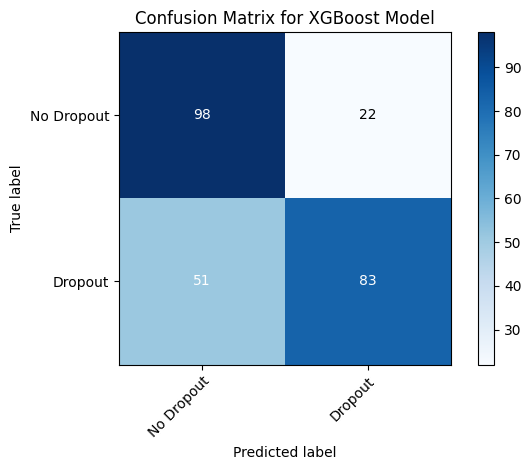

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Assuming X_train and X_test are your feature matrices and y_train and y_test are your labels

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Keep the rest of the columns unchanged
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=300, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Get the probability scores
y_train_probs = pipeline.predict_proba(X_train)[:, 1]
y_test_probs = pipeline.predict_proba(X_test)[:, 1]

# Convert the probabilities to binary
y_train_preds = (y_train_probs > 0.5).astype(int)
y_test_preds = (y_test_probs > 0.5).astype(int)

# Calculate the c-index
print(f"Train C-Index: {helper.cindex(y_train.values, y_train_probs)}")
print(f"Test C-Index: {helper.cindex(y_test.values, y_test_probs)}")

# Plot the confusion matrix
helper.plot_confusion_matrix(y_test, y_test_preds, ['No Dropout', 'Dropout'], title='Confusion Matrix for XGBoost Model');

In [6]:
import shap

# Assuming the previous code has been executed and the pipeline is already fitted

# Extract the fitted model from the pipeline
model = pipeline.named_steps['classifier']


# Create the SHAP explainer using the fitted model and the preprocessed training data
explainer = shap.Explainer(model, pipeline.named_steps['preprocessor'].transform(X_train))

# Calculate SHAP values for the training set
shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X_train))

# Get the feature names from the preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Remove prefixes from the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# Create a SHAP values object with feature names
shap_values_with_names = shap.Explanation(values=shap_values.values, 
                                          base_values=shap_values.base_values, 
                                          data=shap_values.data, 
                                          feature_names=clean_feature_names)


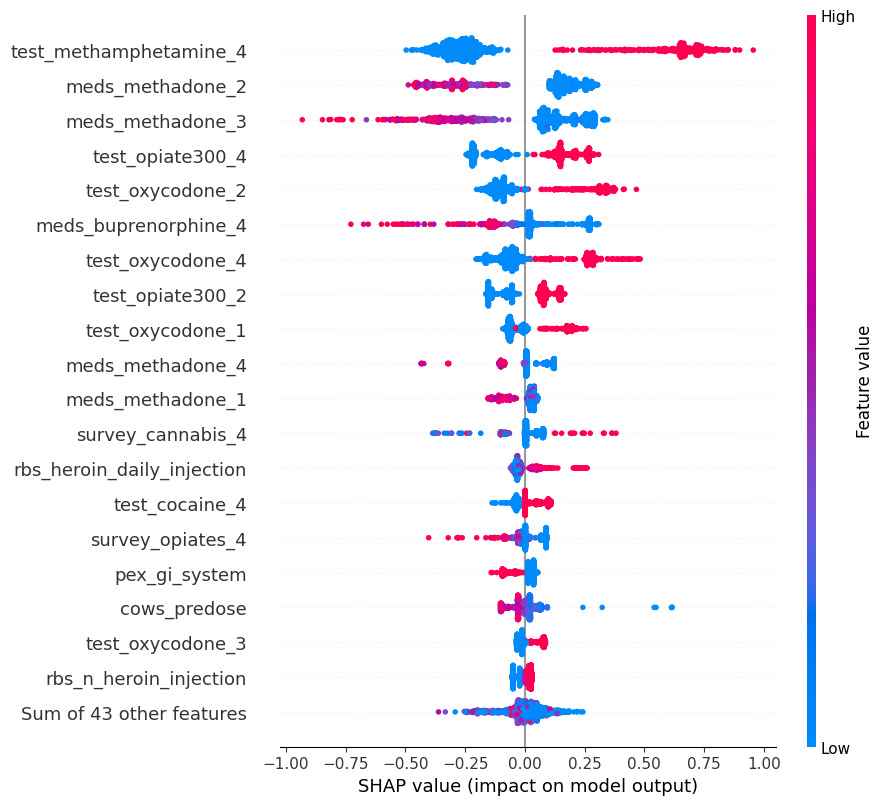

In [7]:

# Plot the SHAP beeswarm plot with feature names
shap.plots.beeswarm(shap_values_with_names, max_display=20, show=True)

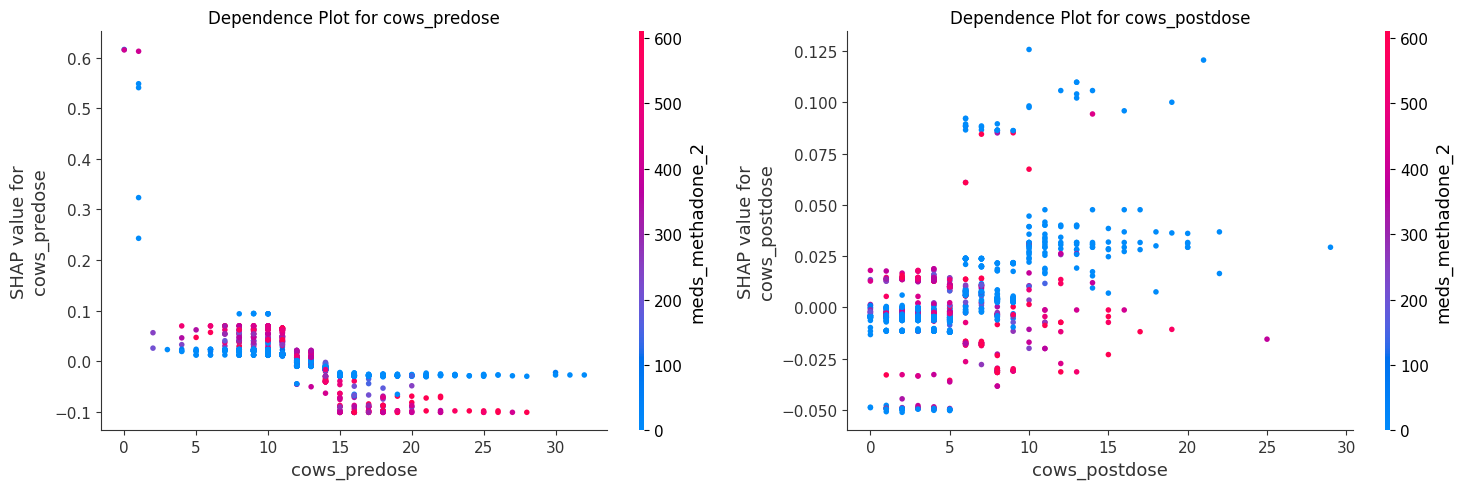

In [8]:
# create array object for dependence plot
shap_values_array = shap_values_with_names.values

# interaction 1
feature1 = 'cows_predose'
feature2 = 'meds_methadone_2'

# interaction 2 
feature3 = 'cows_postdose'
feature4 = 'meds_methadone_2'

helper.plot_dependence(feature1, feature2, feature3, feature4, shap_values_array, X_train)

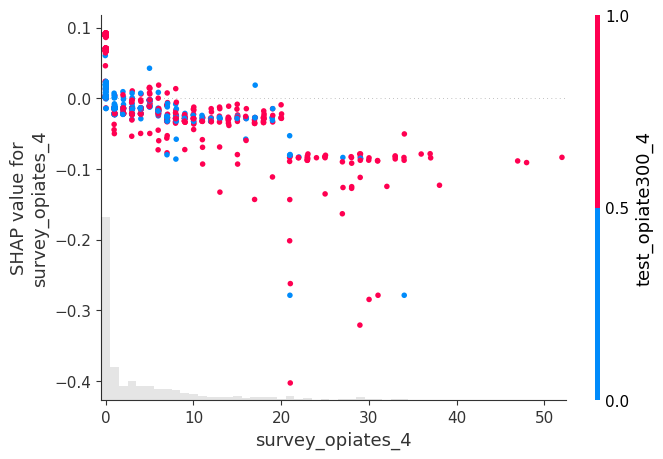

In [9]:
shap.plots.scatter(shap_values_with_names[:, 'survey_opiates_4'], color=shap_values_with_names[:, 'test_opiate300_4'], show=True)

## Look for Interactions - Self Reported Use with Opiate Tests

## Look for Interactions - Self Reported Use with Opiate Tests

In [ ]:
# clustering features
clustering = shap.utils.hclust(X_test, y_test)

shap.plots.bar(shap_values, clustering=clustering)

In [ ]:
# clustering features
clustering = shap.utils.hclust(X_test, y_test)

shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.5)

Class index: 1
Data index: 553


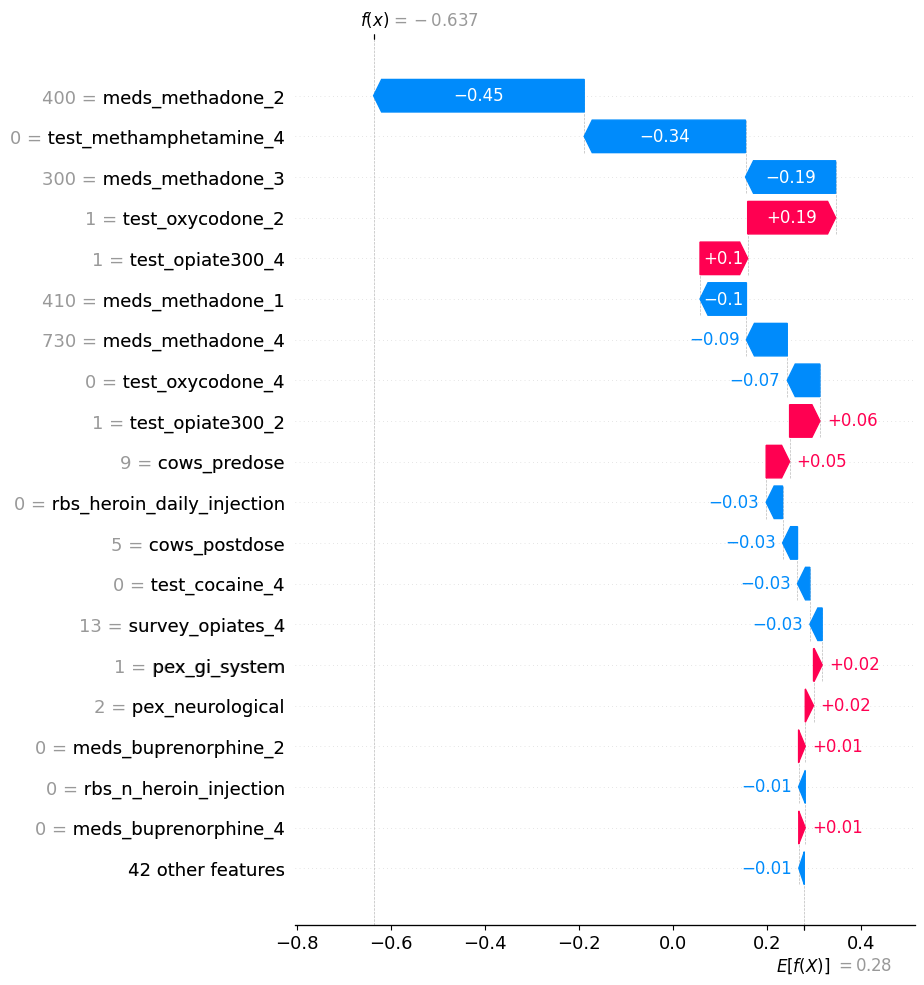

In [11]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values_with_names.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values_with_names[0], max_display=20, show=True)

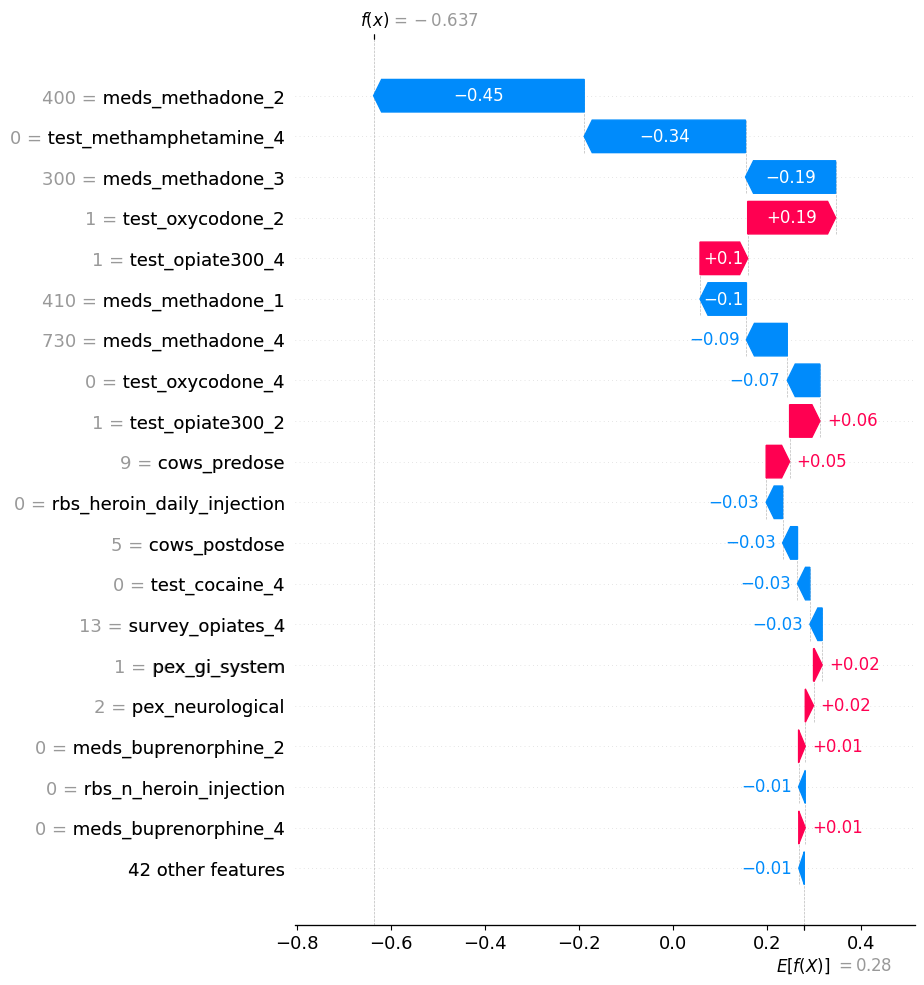

In [12]:
shap.plots.waterfall(shap_values_with_names[0], max_display=20, show=True)

Class index: 1
Data index: 393


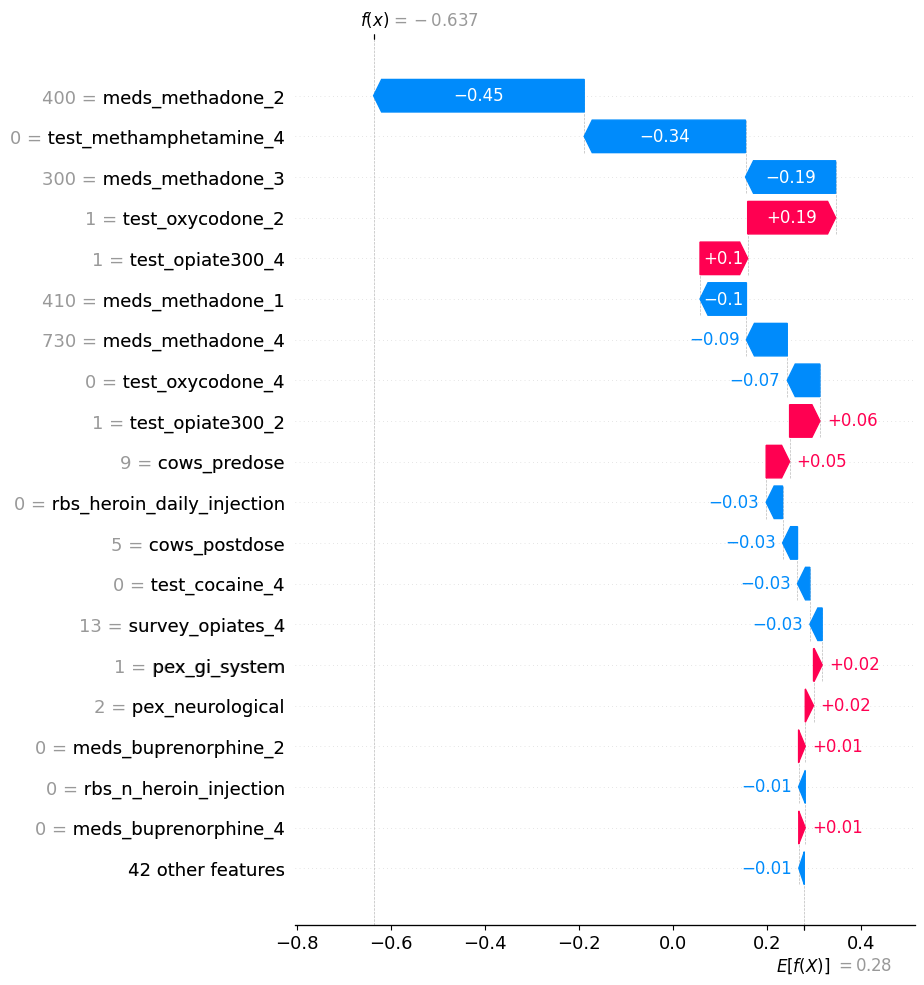

In [13]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values_with_names[0], max_display=20, show=True)

Class index: 1
Data index: 661


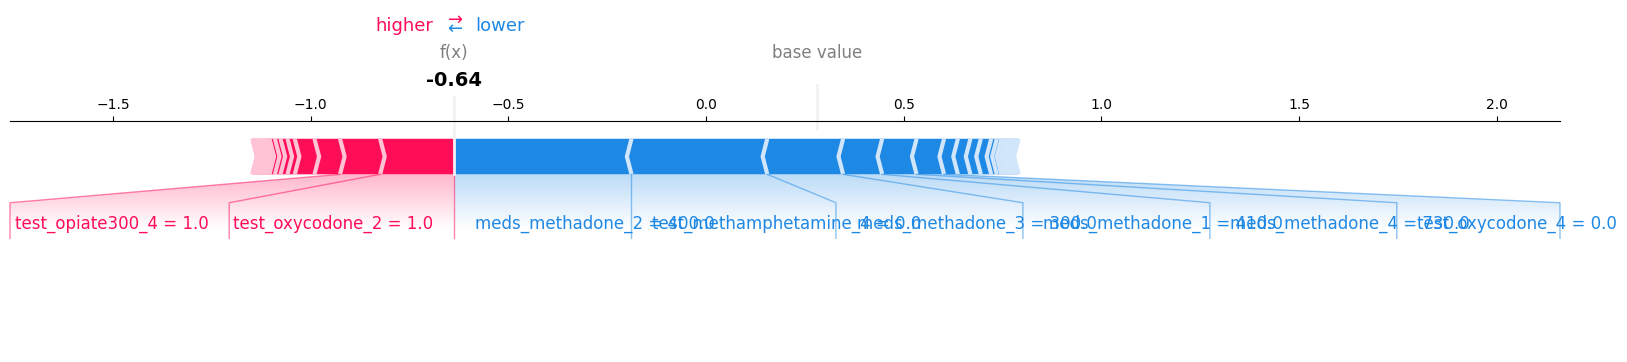

In [14]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values_with_names[0], matplotlib=True)